---
# Student performance : predict student performance in secondary education (high school).
---

In this notebook, we will analyze high school student performance and try to predict it. Being able to predict student performance successfully means understanding the main features influencing it. We can therefore focus our effort on these aspects to improve student performance and the education system more generally.

## Import libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data description and exploration

In [13]:
file = 'student-performance/student-mat.csv'

df = pd.read_csv(file, delimiter=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Let's analyze the available features. We can group them into categories and at a first glance, all of them might influence school performance

*(student-mat.csv & student-por.csv)*


1. Demographic and Family Background

Describes the student’s personal and family context.

- `school` – student's school  
- `sex` – student's sex  
- `age` – student's age  
- `address` – home address type (urban/rural)  
- `famsize` – family size  
- `Pstatus` – parent's cohabitation status  
- `Medu` – mother’s education  
- `Fedu` – father’s education  
- `Mjob` – mother’s job  
- `Fjob` – father’s job  
- `guardian` – student’s guardian  


2. Socioeconomic and Environmental Context

Captures environmental and social factors that may influence learning.

- `reason` – reason for choosing school
- `traveltime` – travel time from home to school 
- `internet` – internet access at home  
- `nursery` – attended nursery school  
- `higher` – intention to pursue higher education  
- `romantic` – relationship status  


3. Academic Effort and Support

Reflects academic habits, support mechanisms, and motivation.

- `studytime` – weekly study time  
- `failures` – number of past class failures  
- `schoolsup` – extra educational support  
- `famsup` – family educational support  
- `paid` – extra paid classes  
- `activities` – extracurricular activities  


4. Behavioral and Social Engagement

Represents lifestyle, leisure, and socialization patterns.

- `freetime` – free time after school  
- `goout` – frequency of going out with friends  
- `Dalc` – workday alcohol consumption  
- `Walc` – weekend alcohol consumption  


5. Well-being and Family Relationships

Indicates health and home environment quality.

- `famrel` – quality of family relationships  
- `health` – current health status  
- `absences` – number of school absences  


6. Academic Performance (Targets)

These are the primary outcome variables.

- `G1` – first period grade  
- `G2` – second period grade  
- `G3` – final grade (output target)


In [14]:
# Get categorical columns (non-numeric)
categorical_cols = df.select_dtypes(exclude="number").columns

# Generate one boxplot per categorical variable
for col in categorical_cols:
    fig = px.box(df, x=col, y="G3", title=f"G3 distribution by {col}", points="all")
    fig.show()

In [15]:
# Select only numeric columns to avoid categorical issues
numeric_cols = df.select_dtypes(include="number").columns.tolist()

# Exclude G3 for X variables
x_cols = [c for c in numeric_cols if c != "G3"]

# Create subplot grid (2 columns for readability)
rows = (len(x_cols) + 1) // 2
fig = sp.make_subplots(rows=rows, cols=2, subplot_titles=x_cols)

for i, col in enumerate(x_cols):
    r, c = divmod(i, 2)
    fig.add_trace(
        go.Scatter(
            x=df[col],
            y=df["G3"],
            mode="markers",
            marker=dict(size=4, opacity=0.6),
            name=col
        ),
        row=r + 1,
        col=c + 1
    )

fig.update_layout(
    height=300 * rows,
    title_text="Relationships between G3 and Other Numeric Attributes",
    showlegend=False
)
fig.update_xaxes(title_text="Feature value")
fig.update_yaxes(title_text="G3 (Final Grade)")
fig.show()

Past performace : grades, absences and failures seem to have an influence

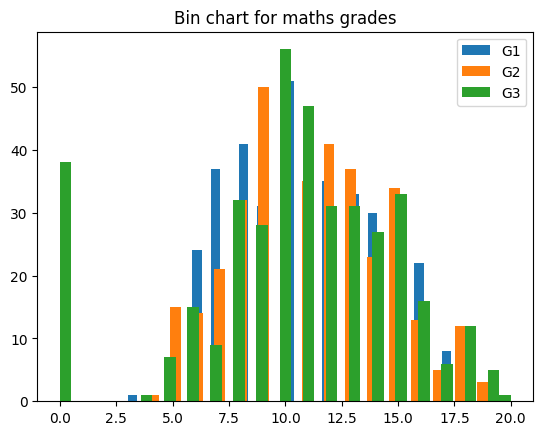

In [16]:
G1 = df['G1']
G2 = df['G2']
G3 = df['G3']

plt.figure()
plt.hist(G1, bins=len(G1)//10, label='G1')
plt.hist(G2, bins=len(G2)//10, label='G2')
plt.hist(G3, bins=len(G3)//10, label='G3')
plt.title('Bin chart for maths grades')
plt.legend()

G1, G2 and G3 grades seem to follow the same distribution. It is a phenomenon commonly observed. Now it does not mean that the students get the same grades from G1 to G3.

## Determine cluster via dimensionality reduction : unsupervised learning

### Principal Component Analysis

In [21]:
# Select only numeric columns (exclude categorical for PCA)
X = df.select_dtypes(include='number').dropna()

# Standardize the features (important for PCA)
X_scaled = StandardScaler().fit_transform(X.drop(columns=['G3']))

# Fit PCA
N_COMPONENTS = 5
pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratio:", pca.explained_variance_ratio_)
print("PCA explained total variance ratio:", sum(pca.explained_variance_ratio_))

# Component loadings (feature contributions)
loadings = pd.DataFrame(
    pca.components_,
    columns=X.drop(columns=['G3']).columns,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

loadings

PCA explained variance ratio: [0.18900895 0.13312387 0.09221904 0.08511214 0.07795384]
PCA explained total variance ratio: 0.5774178272598405


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
PC1,-0.209981,0.262436,0.247732,-0.186901,0.219002,-0.360763,0.019097,-0.127487,-0.239326,-0.282449,-0.317538,-0.088641,-0.076858,0.413880,0.416001
PC2,-0.022706,0.381438,0.368389,-0.051048,-0.157966,-0.117340,-0.026541,0.263082,0.343477,0.431120,0.436137,0.039755,0.141004,0.207621,0.220021
PC3,0.265643,-0.396959,-0.435853,0.223417,0.050037,-0.014470,-0.099789,0.007199,-0.067377,0.189163,0.181808,-0.164811,0.032194,0.459731,0.454228
PC4,-0.140053,-0.159237,-0.134580,-0.034486,0.001984,-0.037206,0.544291,0.526007,0.161636,-0.059254,-0.084535,0.318076,-0.456714,0.100569,0.068887
PC5,0.555047,0.110106,0.002646,-0.272138,0.328216,0.124749,0.383931,0.128677,0.264622,-0.140926,-0.152081,-0.286848,0.348326,0.023829,-0.035935


This shows the features with the highest contribution in the first few principal components. We can explain 90% of the variance from 11 components.

In [22]:
# Create a DataFrame for visualization
# Define the desired number of principal components


# Generate the list using a list comprehension
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, N_COMPONENTS + 1)])
pca_df['G3'] = X['G3']

# --- 2D PCA Plot ---
fig2d = px.scatter(
    pca_df, x='PC1', y='PC2',
    color='G3',
    color_continuous_scale='Viridis',
    title='2D PCA Projection Colored by G3',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'}
)
fig2d.show()

# --- 3D PCA Plot ---
fig3d = px.scatter_3d(
    pca_df, x='PC1', y='PC2', z='PC3',
    color='G3',
    color_continuous_scale='Viridis',
    title='3D PCA Projection Colored by G3'
)
fig3d.show()

Whether it is in the 2D or 3D plot, the PCA projects the points with similar G3 grade to similar locations

## Fit supervised learning algorithm

### Regression : trying to predict exact mark

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.metrics import root_mean_squared_error

In [24]:
#Split dataset into training and test set
X = df.drop(columns=['G3'])
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
### Hyperparameter tuning with train test val split. Nested or non nested cross validation ?

### Choose best model ?

### Gaussian process

In [ ]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# X_train = X_train[['G1', 'G2']] # much better results after feature selection. Show that feature engineering is very important with this example


categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])


kernel = RBF(1.0)

gpr = GaussianProcessRegressor(kernel, random_state=42)
model = Pipeline([
    ('preprocess', preprocessor),
    ('model', gpr)
])

model.fit(X_train, y_train) # Kernel hyperparameters already fitted when calling .fit() method

print('Initial kernel:', gpr.kernel)
print('Optimal kernel:', gpr.kernel_)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE =', rmse)


Initial kernel: RBF(length_scale=1)
Optimal kernel: RBF(length_scale=5.12)
RMSE = 2.3815904609224874


### Decision tree

In [ ]:
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

dt = DecisionTreeRegressor(random_state=42)
model = Pipeline([
    ('preprocess', preprocessor),
    ('model', dt)
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE =', rmse)

RMSE = 2.3411562652304627


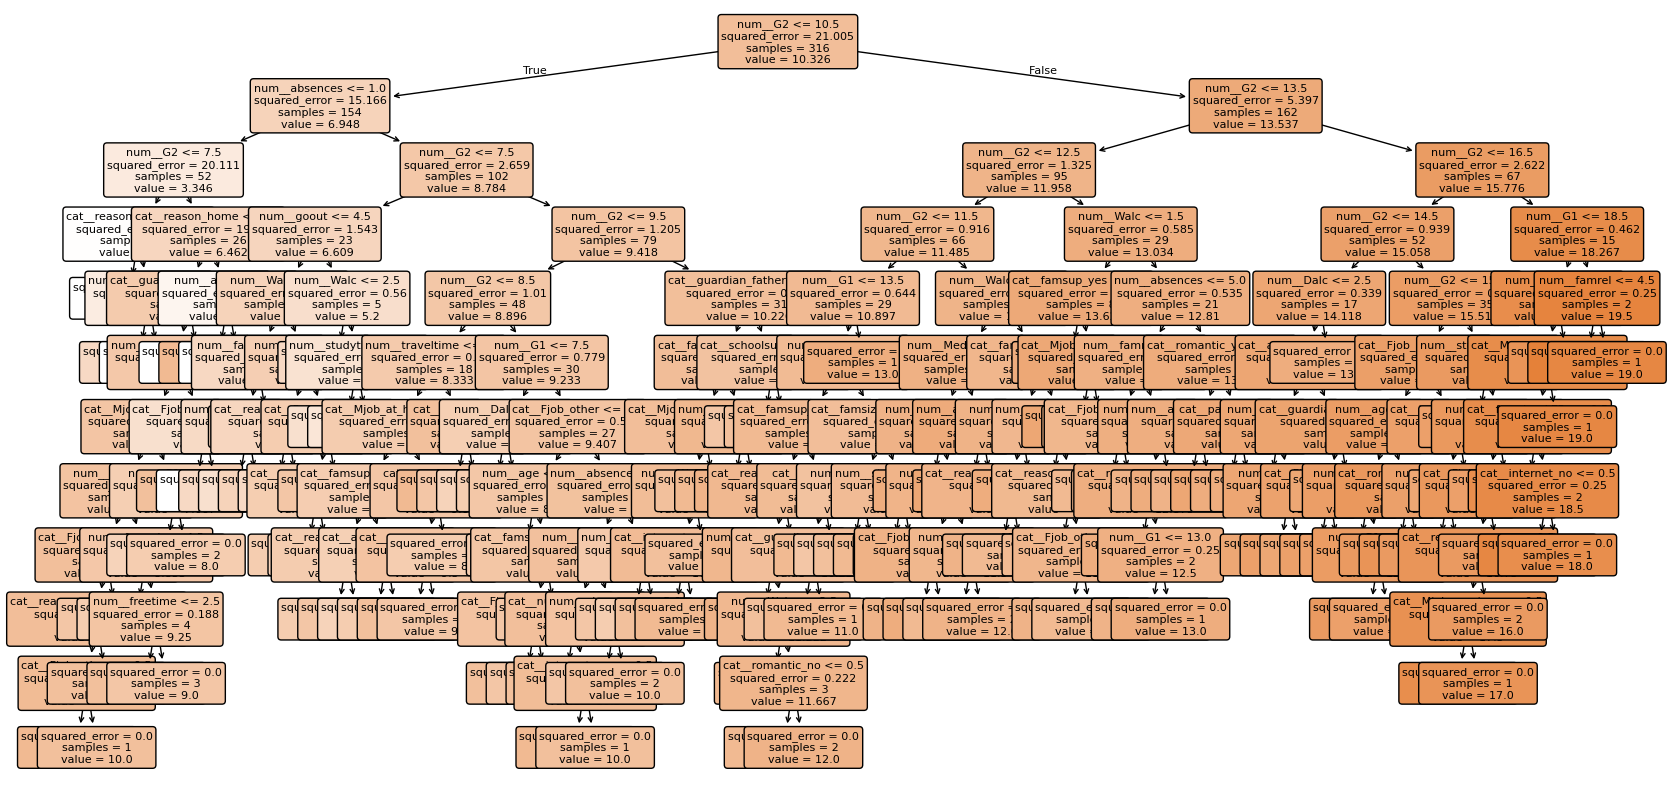

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# Extract fitted DecisionTreeRegressor from pipeline
dt_model = model.named_steps['model']

plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt_model,
    feature_names=model.named_steps['preprocess'].get_feature_names_out(),
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()

In [34]:
# Hyperparameter tuning
from bayes_opt import BayesianOptimization


# Define the function to optimize using cross-validation
def dtree_cv(max_depth, min_samples_split, min_samples_leaf):
    # Define the model with the parameters to be optimized

    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ])

    dt = DecisionTreeRegressor(max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               random_state=42)
    model = Pipeline([
        ('preprocess', preprocessor),
        ('model', dt)
    ])
    
    cval = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    return cval.mean() # The optimizer tries to maximize the function, so we negate the score to minimize it


# Define the parameter bounds
param_bounds = {
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20)
}

optimizer = BayesianOptimization(
    f=dtree_cv,
    pbounds=param_bounds,
    random_state=42,
)

optimizer.maximize(n_iter=25, init_points=5) # Bayesian optimization
best_params_bayes = optimizer.max['params']
best_params_bayes['max_depth'] = int(best_params_bayes['max_depth'])
best_params_bayes['min_samples_split'] = int(best_params_bayes['min_samples_split'])
best_params_bayes['min_samples_leaf'] = int(best_params_bayes['min_samples_leaf'])
best_score_bayes = optimizer.max['target']

print(f"Best Parameters (Bayesian Optimization): {best_params_bayes}")
print(f"Best Score (Bayesian Optimization): {best_score_bayes}")


|   iter    |  target   | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------
| 1         | -4.035844 | 8.1162622 | 19.112857 | 14.907884 |
| 2         | -4.599661 | 12.374511 | 4.8083355 | 3.9638958 |
| 3         | -6.285326 | 2.1035886 | 17.591170 | 12.421185 |
| 4         | -4.202277 | 14.453378 | 2.3705208 | 19.428287 |
| 5         | -4.246743 | 16.816410 | 5.8221039 | 4.4546743 |
| 6         | -3.950744 | 9.3603248 | 19.474471 | 15.739155 |
| 7         | -3.825382 | 13.078652 | 18.590574 | 11.671755 |
| 8         | -3.950744 | 13.710396 | 13.630445 | 15.291790 |
| 9         | -3.939852 | 18.837003 | 14.730007 | 9.8470895 |
| 10        | -3.950744 | 19.029223 | 19.614819 | 15.680117 |
| 11        | -4.408247 | 17.051012 | 20.0      | 4.6828525 |
| 12        | -3.960843 | 20.0      | 11.436258 | 16.835369 |
| 13        | -3.934534 | 20.0      | 5.9547084 | 12.096419 |
| 14        | -10.93394 | 1.0       | 2.0       | 20.0      |
| 15    

### XGBoost Regressor

In [30]:
import xgboost as xgb

categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

xgbr = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,      # Number of boosting rounds (trees)
    learning_rate=0.1,     # Step size shrinkage
    max_depth=5,           # Maximum tree depth
    random_state=42,
    # Use 'hist' for faster tree construction
    tree_method='hist' 
)

model = Pipeline([
    ('preprocess', preprocessor),
    ('model', xgbr)
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE =', rmse)


RMSE = 2.1511070728302


In [ ]:


categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

dt = DecisionTreeRegressor(random_state=42)
model = Pipeline([
    ('preprocess', preprocessor),
    ('model', dt)
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE =', rmse)

### Automatic feature selection : BIC ? Lasso ? Forward etc...

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)

model = Pipeline([
    ('preprocess', preprocessor),
    ('feature_select', SelectFromModel(lsvc)),
])

# X_train_reduced = model.fit_transform(X_train, y_train)
# print(X_train_reduced.shape)

model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('feature_select', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [91]:
# Get OneHotEncoder from pipeline
ohe = model.named_steps['preprocess'].named_transformers_['cat']

# Get the feature names after encoding
encoded_cat_features = ohe.get_feature_names_out(categorical_cols)

# Combine with numeric features
all_features = list(encoded_cat_features) + list(numeric_cols)

# Get boolean mask of selected features
selector = model.named_steps['feature_select']
mask = selector.get_support()

# Keep only selected features
selected_features = [f for f, keep in zip(all_features, mask) if keep]

print(f"Selected {len(selected_features)} features out of {len(all_features)}:")
print(selected_features)


Selected 4 features out of 58:
['age', 'absences', 'G1', 'G2']


In [106]:
X_train_reduced = X_train[selected_features]

# Decision tree
categorical_cols = X_train_reduced.select_dtypes(include=['object']).columns
numeric_cols = X_train_reduced.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

dt = DecisionTreeRegressor(random_state=42)
model = Pipeline([
    ('preprocess', preprocessor),
    ('model', dt)
])

model.fit(X_train_reduced, y_train)
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE DT =', rmse)


# Gaussian Process
kernel = RBF(1.0)

gpr = GaussianProcessRegressor(kernel, random_state=42)
model = Pipeline([
    ('preprocess', preprocessor),
    ('model', gpr)
])

model.fit(X_train_reduced, y_train) # Kernel hyperparameters already fitted when calling .fit() method

print('Initial kernel:', gpr.kernel)
print('Optimal kernel:', gpr.kernel_)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE GP =', rmse)

RMSE DT = 2.2448565997197245
Initial kernel: RBF(length_scale=1)
Optimal kernel: RBF(length_scale=1e-05)
RMSE GP = 10.671148847310358


/home/mqtho/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning:

The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



## BONUS : predict other attributes using grades.

Expected outcome: it's impossible. Grades don't define people.